
 
Модель классификации статуса стартапа. 
===============


Основные этапы исследования:
- загрузка и ознакомление с данными
- предварительная обработка
- разведочный анализ
- разработка новых синтетических признаков
- проверка на мультиколлинеарность
- отбор финального набора обучающих признаков
- выбор и обучение моделей
- итоговая оценка качества предсказания лучшей модели
- анализ важности ее признаков
- отчет по исследованию

In [46]:
#загрузка библиотек для работы с данными
import numpy as np
import pandas as pd

#загрузка библиотек для анализа корреляции
import phik

#загрузка библиотек для работы с графиками
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# загружаем класс pipeline
from sklearn.pipeline import Pipeline


# загружаем классы для подготовки данных
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (OneHotEncoder, 
                                   StandardScaler,
                                   RobustScaler,
                                   MinMaxScaler)

from sklearn.compose import ColumnTransformer

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем функцию для работы с метриками
from sklearn.metrics import (roc_auc_score,
                             accuracy_score,
                             f1_score)


# импортируем класс GridSearchCV
from sklearn.model_selection import GridSearchCV

# загружаем нужные модели
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

#загружаем модуль проверки признаков
import shap

# Загрузка, изучение данных, преподготовка данных
## Загрузка данных

In [2]:
train_df = pd.read_csv('kaggle_startups_train_01.csv')
test_df = pd.read_csv('kaggle_startups_test_01.csv')

## Изучение данных
### Изучение тренировачных данных

In [3]:
#Вывод основной информации о датафрейме
def data_exploration(dataframe):
    print('\033[0m')
    print('\033[1m' + 'Информация о датафрейме:')
    print('\033[0m')
    display(dataframe.info())
    print('\033[0m')
    print('\033[1m' + 'Первые пять строк:')
    print('\033[0m')
    display(dataframe.head())

In [4]:
data_exploration(train_df)


Информация о датафрейме:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52879 entries, 0 to 52878
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52878 non-null  object 
 1   category_list      50374 non-null  object 
 2   funding_total_usd  42753 non-null  float64
 3   status             52879 non-null  object 
 4   country_code       47351 non-null  object 
 5   state_code         46082 non-null  object 
 6   region             46489 non-null  object 
 7   city               46489 non-null  object 
 8   funding_rounds     52879 non-null  int64  
 9   founded_at         52879 non-null  object 
 10  first_funding_at   52858 non-null  object 
 11  last_funding_at    52879 non-null  object 
 12  closed_at          4962 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB


None


Первые пять строк:



,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2010-06-24,2011-05-01,2014-12-01,NaN
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-07-30,2012-02-01,2012-02-01,NaN


- __name__ - Название стартапа 
- __category_list__ - Индустрия в которой работает стартап
- __funding_total_usd__ - Объем инвестиций
- __status__ - статус функционирования (целевой признак)
- __country_code__ - страна 
- __state_code__ - штат
- __region__ - Регион стартапа
- __city__ - Город где функционирует стартап
- __funding_rounds__ - число раундов финансирования
- __founded_at__ - дата создания стартапа
- __first_funding_at__ - дата первого раунда финансирования
- __last_funding_at__ - дата последнего раунда финансирования
- __closed_at__ - дата закрытия стартапа

### Изучение тестовых данных

In [5]:
data_exploration(test_df)


Информация о датафрейме:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13211 entries, 0 to 13210
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13211 non-null  object 
 1   category_list      12610 non-null  object 
 2   funding_total_usd  10616 non-null  float64
 3   country_code       11827 non-null  object 
 4   state_code         11512 non-null  object 
 5   region             11618 non-null  object 
 6   city               11620 non-null  object 
 7   funding_rounds     13211 non-null  int64  
 8   founded_at         13211 non-null  object 
 9   first_funding_at   13211 non-null  object 
 10  last_funding_at    13211 non-null  object 
 11  closed_at          1234 non-null   object 
dtypes: float64(1), int64(1), object(10)
memory usage: 1.2+ MB


None


Первые пять строк:



,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2008-06-01,2009-07-01,2009-07-01,NaN
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-25,2010-07-28,2010-07-28,NaN
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-06-16,2014-05-15,2014-09-18,NaN
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2005-01-01,2010-04-20,NaN
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2001-01-01,2007-05-08,2007-05-08,NaN


## Заключение по ознакомлению с данными
- Тренировочные данные представлены таблицей размерностью 52879 строк и 13 столбцов
- Тестовые данные представлены 13211 строк и 12 столбцов
- Содержание столбцов схоже, в тестовых данных отсутствует столбец с целевым признаком

# Предподготовка данных
## Изменение типа данных 
### Изменение типа данных в тренировочном датасете

In [6]:
#Поменяем тип данных для дат
train_df['founded_at'] = pd.to_datetime(train_df['founded_at'], format='%Y-%m-%d')
train_df['first_funding_at'] = pd.to_datetime(train_df['first_funding_at'], format='%Y-%m-%d')
train_df['last_funding_at'] = pd.to_datetime(train_df['last_funding_at'], format='%Y-%m-%d')
train_df['closed_at'] = pd.to_datetime(train_df['closed_at'], format='%Y-%m-%d')

### Изменение типа данных в тестовом датасете

In [7]:
#Поменяем тип данных для дат
test_df['founded_at'] = pd.to_datetime(test_df['founded_at'], format='%Y-%m-%d')
test_df['first_funding_at'] = pd.to_datetime(test_df['first_funding_at'], format='%Y-%m-%d')
test_df['last_funding_at'] = pd.to_datetime(test_df['last_funding_at'], format='%Y-%m-%d')
test_df['closed_at'] = pd.to_datetime(test_df['closed_at'], format='%Y-%m-%d')

## Поиск пропусков и дубликатов
### Поиск пропусков и дубликатов в тренировочном файле

In [8]:
#Проверка на отсутствие пропусков и дупликатов
print('Пропуски в строках таблицы train_df')
display(pd.DataFrame((round(train_df.isna().mean()*100)))
        .style.background_gradient('coolwarm'))
print('Дубликаты train_df', train_df.duplicated().sum())

Пропуски в строках таблицы train_df


,0
name,0.000000
category_list,5.000000
funding_total_usd,19.000000
status,0.000000
country_code,10.000000
state_code,13.000000
region,12.000000
city,12.000000
funding_rounds,0.000000
founded_at,0.000000


Дубликаты train_df 0


- В тренировочном файле дубликаты не выявлены
- 91% наблюдений не содержит информацию о том, когда закрылись компании, а следовательно предполагаем, что они еще работают.
- 5% наблюдений не содержат информацию в каком рынке функционирует стартап
- 10% не содержит информацию о стране происхождения
- 13% о штате происхождения 
- 12% не содержин информацию о регионе происхождения
- 12% не содержит информацию о городе происхождения
- Дубликаты не выявлены

__Проведем дополнительный анализ об отсутствующей информации для закрытых стартапов__

In [9]:
#Проверка на пропуски в закрытых стартапах
print('Пропуски в строках таблицы train_df')
display(pd.DataFrame(round(train_df[train_df['status'] == 'closed'].isna().mean()*100,))
        .style.background_gradient('coolwarm'))

Пропуски в строках таблицы train_df


,0
name,0.000000
category_list,15.000000
funding_total_usd,21.000000
status,0.000000
country_code,26.000000
state_code,28.000000
region,28.000000
city,28.000000
funding_rounds,0.000000
founded_at,0.000000


Похоже, что для закрытых стартапов характерно отсутствие информации об их происхождении. Возможно использовать данный инсайт для создания нового признака. 

In [10]:
#Заменим отсутствующую категорийную информацию на заглушку для категории
train_df['category_list'] = train_df['category_list'].fillna('Unknown_category')
train_df['country_code'] = train_df['country_code'].fillna('Unknown_country')
train_df['state_code'] = train_df['state_code'].fillna('Unknown_state')
train_df['region'] = train_df['region'].fillna('Unknown_region')
train_df['city'] = train_df['city'].fillna('Unknown_city')

#Заменим отсутствующую информацию о финансировании на 0
train_df['funding_total_usd'] = train_df['funding_total_usd'].fillna(0)

#Заменим отсутствующую временную информацию на заглушку для категории
train_df.closed_at.fillna(pd.to_datetime('2018-01-01'), inplace=True)

In [11]:
#Проверка на отсутствие пропусков и дупликатов
print('Пропуски в строках таблицы train_df')
display(pd.DataFrame(round(train_df.isna().mean()*100,))
        .style.background_gradient('coolwarm'))
print('Дубликаты train_df', train_df.duplicated().sum())

Пропуски в строках таблицы train_df


,0
name,0.000000
category_list,0.000000
funding_total_usd,0.000000
status,0.000000
country_code,0.000000
state_code,0.000000
region,0.000000
city,0.000000
funding_rounds,0.000000
founded_at,0.000000


Дубликаты train_df 0


### Поиск пропусков и дубликатов в тестовом файле

In [12]:
#Проверка на отсутствие пропусков и дупликатов
print('Пропуски в строках таблицы test_df')
display(pd.DataFrame(round(test_df.isna().mean()*100,))
        .style.background_gradient('coolwarm'))
print('Дубликаты test_df', test_df.duplicated().sum())

Пропуски в строках таблицы test_df


,0
name,0.000000
category_list,5.000000
funding_total_usd,20.000000
country_code,10.000000
state_code,13.000000
region,12.000000
city,12.000000
funding_rounds,0.000000
founded_at,0.000000
first_funding_at,0.000000


Дубликаты test_df 0


- В тренировочном файле дубликаты не выявлены
- 91% наблюдений не содержит информацию о том, когда закрылись компании, а следовательно предполагаем, что они еще работают.
- 5% наблюдений не содержат информацию в каком рынке функционирует стартап
- 10% не содержит информацию о стране происхождения
- 12% о штате происхождения 
- 12% не содержин информацию о регионе происхождения
- 12% не содержит информацию о городе происхождения
- Дубликаты не выявлены

Датасет имеет аналогичный объем пропусков

In [13]:
#Заменим отсутствующую категорийную информацию на заглушку для категории
test_df['category_list'] = test_df['category_list'].fillna('Unknown_category')
test_df['country_code'] = test_df['country_code'].fillna('Unknown_country')
test_df['state_code'] = test_df['state_code'].fillna('Unknown_state')
test_df['region'] = test_df['region'].fillna('Unknown_region')
test_df['city'] = test_df['city'].fillna('Unknown_city')

#Заменим отсутствующую информацию о финансировании на 0
test_df['funding_total_usd'] = test_df['funding_total_usd'].fillna(0)

#Заменим отсутствующие даты в столбце closed_at на дату загрузки данных (2018-01-01)
test_df['closed_at'] = test_df['closed_at'].fillna('2018-01-01')

In [14]:
#Проверка на отсутствие пропусков и дупликатов
print('Пропуски в строках таблицы test_df')
display(pd.DataFrame(round(test_df.isna().mean()*100,))
        .style.background_gradient('coolwarm'))
print('Дубликаты test_df', test_df.duplicated().sum())

Пропуски в строках таблицы test_df


,0
name,0.000000
category_list,0.000000
funding_total_usd,0.000000
country_code,0.000000
state_code,0.000000
region,0.000000
city,0.000000
funding_rounds,0.000000
founded_at,0.000000
first_funding_at,0.000000


Дубликаты test_df 0


## Заключение по предподготовке данных

__Тренировочный датасет и тестовый датасет имеют схожую статистику по пропускам__ 

- В тренировочном файле дубликаты не выявлены
- 91% наблюдений не содержит информацию о том, когда закрылись компании, а следовательно предполагаем, что они еще работают.
- 5% наблюдений не содержат информацию в каком рынке функционирует стартап
- 10% не содержит информацию о стране происхождения
- 13% о штате происхождения 
- 12% не содержин информацию о регионе происхождения
- 12% не содержит информацию о городе происхождения

__- Отсутствующие данные заменены на заглушки__


## Создание новых признаков

__Cоздадим новые признаки на базе столбцов с датами:__

- lifetime продолжительность жизни стартапа от даты создания до даты закрытия
- funding_length продолжительность жизни стартапа между первым и последним раундом финансирования
- first_funding_lt продолжительность жизни стратапа между первым финансированием и созданием
- funding_life_share - доля жизни стартапа с финансированием

In [44]:
# Сосчитаем разницу между датами
train_df['lifetime'] = (train_df['closed_at'] - train_df['founded_at']).dt.days
train_df['funding_length'] = (train_df['last_funding_at'] - train_df['first_funding_at']).dt.days
train_df['first_funding_lt'] = (train_df['first_funding_at']-train_df['founded_at']).dt.days
train_df['funding_life_share'] = train_df['funding_length'] / train_df['lifetime']

In [16]:
train_df.head(10)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,lifetime,funding_length,first_funding_lt,funding_life_share
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2010-06-24,2011-05-01,2014-12-01,2018-01-01,2748,1310.0,311.0,0.476710
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,2018-01-01,4748,1393.0,1949.0,0.293387
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,2018-01-01,4383,681.0,2423.0,0.155373
3,Sancilio and Company,Health Care,22250000.0,operating,Unknown_country,Unknown_state,Unknown_region,Unknown_city,3,2004-01-01,2011-09-01,2014-07-18,2018-01-01,5114,1051.0,2800.0,0.205514
4,WireTough Cylinders,Manufacturing,0.0,operating,USA,VA,VA - Other,Bristol,1,2010-07-30,2012-02-01,2012-02-01,2018-01-01,2712,0.0,551.0,0.000000
5,Connected Sports Ventures,Mobile,4300000.0,operating,USA,NJ,Newark,Princeton,1,2011-04-21,2012-11-12,2012-11-12,2018-01-01,2447,0.0,571.0,0.000000
6,Attensity,Analytics|Business Analytics|Social CRM|Social...,90000000.0,operating,USA,CA,SF Bay Area,Redwood City,1,2000-01-01,2014-05-14,2014-05-14,2018-01-01,6575,0.0,5247.0,0.000000
7,Mesh Networks,Software,4300000.0,operating,USA,TX,Houston,Houston,1,2005-01-01,2014-11-09,2014-11-09,2018-01-01,4748,0.0,3599.0,0.000000
8,AngioScore,Biotechnology,42000000.0,operating,USA,CA,SF Bay Area,Fremont,2,2003-01-01,2007-10-09,2011-04-20,2018-01-01,5479,1289.0,1742.0,0.235262
9,Vidatronic,Semiconductors,1250500.0,operating,USA,TX,Austin,College Station,2,2010-01-01,2011-08-23,2013-03-21,2018-01-01,2922,576.0,599.0,0.197125


In [17]:
# Сосчитаем разницу между датами для тестовых данных
test_df['lifetime'] = (test_df['closed_at'] - test_df['founded_at']).dt.days
test_df['funding_length'] = (test_df['last_funding_at'] - test_df['first_funding_at']).dt.days
test_df['funding_life_share'] = test_df['funding_length'] / test_df['lifetime']
test_df['first_funding_lt'] = (test_df['first_funding_at']-test_df['founded_at']).dt.days

# Исследовательский анализ данных 



## Изучение количественных данных


In [18]:
#Функция для построения графиков для численных признаков
def num_hist_boxplot(dataframe, num_columns):
    for col in num_columns:
        if col != 'id':
            print()
            print('\033[1m' +'Изучение количественного признака', col)
            print('\033[0m')
            print(dataframe[col].describe())
            fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9,9))
            sns.histplot(ax=axes[0], data=dataframe, x=dataframe[col])
            axes[0].set_title("Гистограмма признака")
            sns.boxplot(ax=axes[1], data=dataframe, y=dataframe[col])
            axes[1].set_title("Разброс признака")
            fig.suptitle('Графики для признака ' + str(col), fontsize=25)
            plt.show()

In [19]:
numerical_columns_dea = train_df.select_dtypes(include=['number'], exclude=['object', 'datetime64']).columns.tolist()
numerical_columns_dea.remove('funding_total_usd')


Изучение количественного признака funding_rounds

count    52879.000000
mean         1.738270
std          1.371993
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         19.000000
Name: funding_rounds, dtype: float64


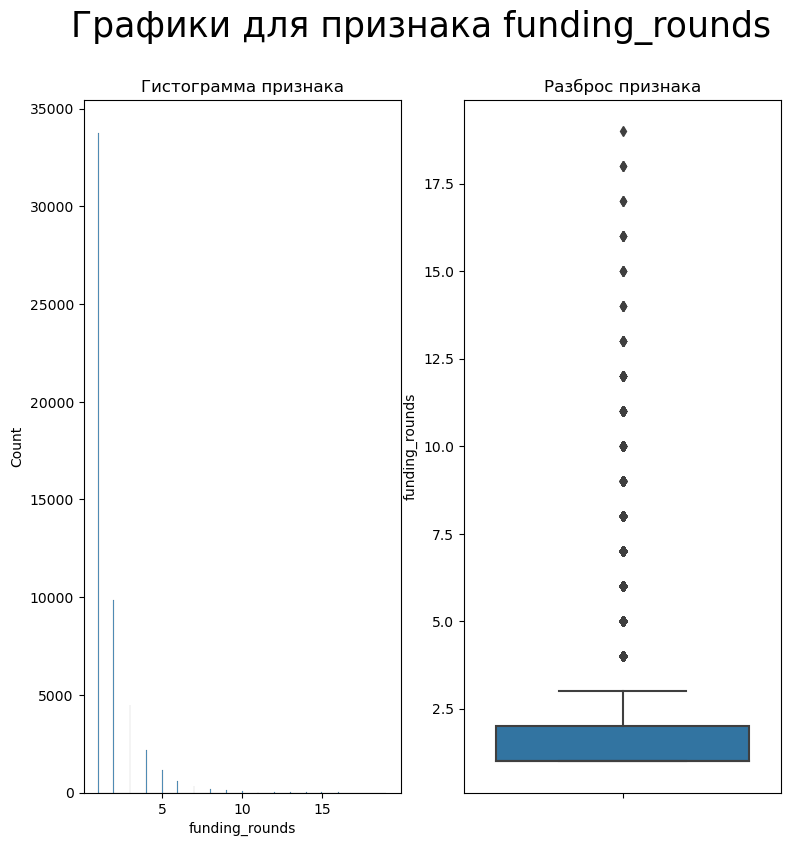


Изучение количественного признака lifetime

count    52879.000000
mean      3317.351406
std       3396.031285
min     -31823.000000
25%       1740.000000
50%       2557.000000
75%       4018.000000
max      98250.000000
Name: lifetime, dtype: float64


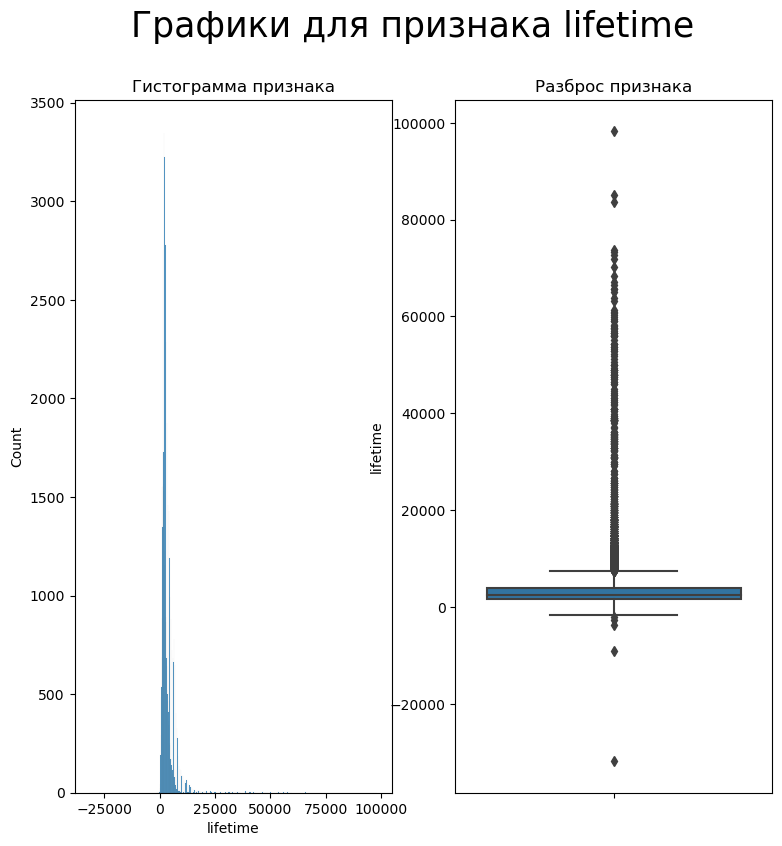


Изучение количественного признака funding_length

count    52858.000000
mean       346.647092
std        724.049585
min          0.000000
25%          0.000000
50%          0.000000
75%        425.000000
max      36994.000000
Name: funding_length, dtype: float64


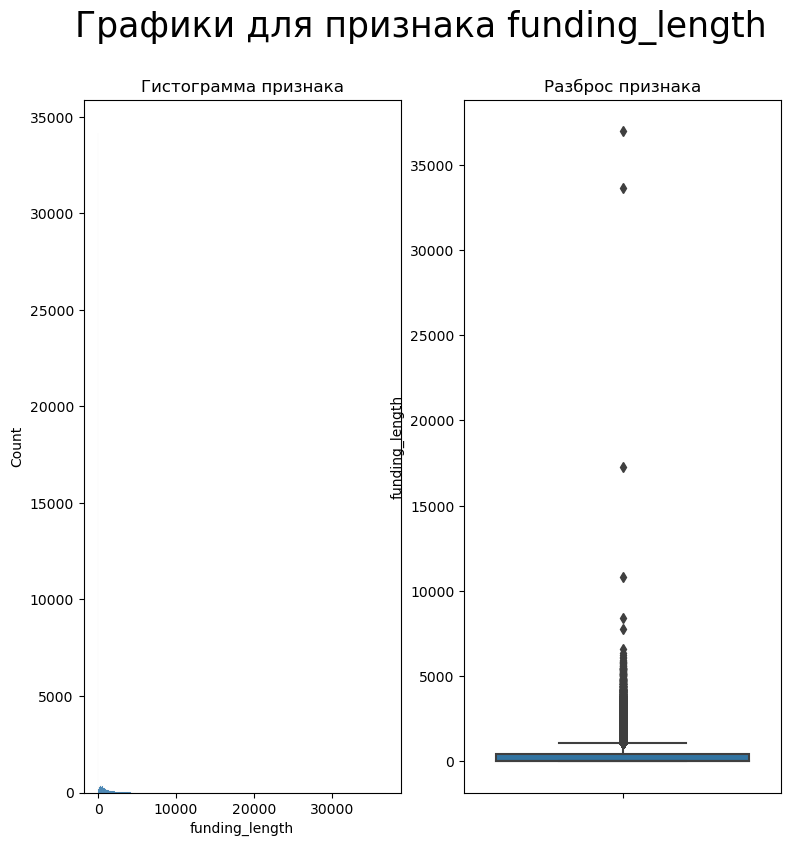


Изучение количественного признака first_funding_lt

count    52858.000000
mean      1162.303965
std       3113.476082
min     -32919.000000
25%        216.000000
50%        482.000000
75%       1003.000000
max      93053.000000
Name: first_funding_lt, dtype: float64


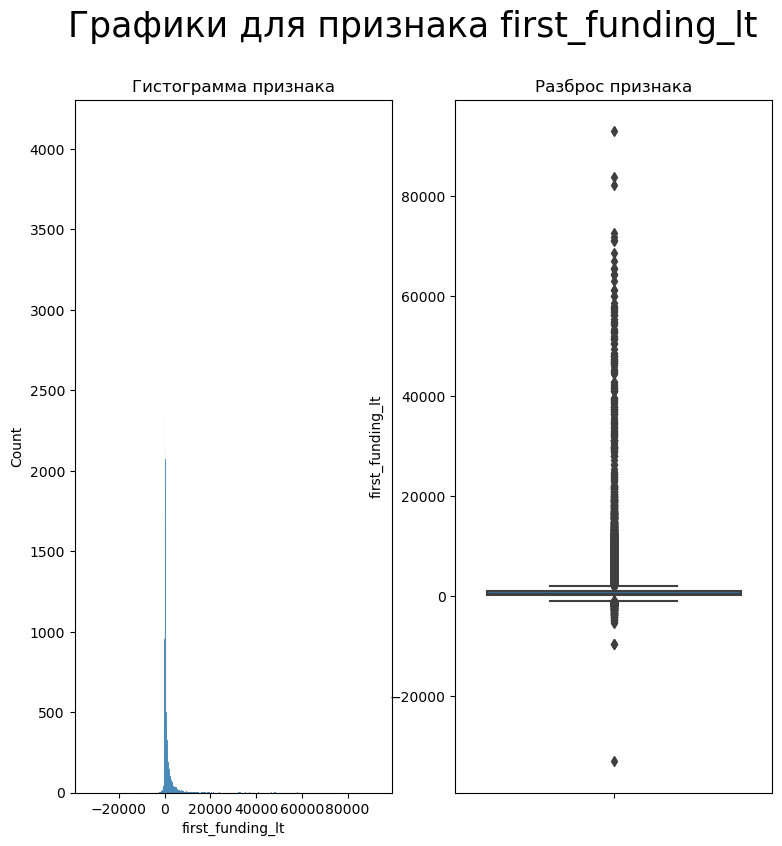


Изучение количественного признака funding_life_share

count    52858.000000
mean         0.102334
std          0.217820
min        -11.421053
25%          0.000000
50%          0.000000
75%          0.158321
max         25.548343
Name: funding_life_share, dtype: float64


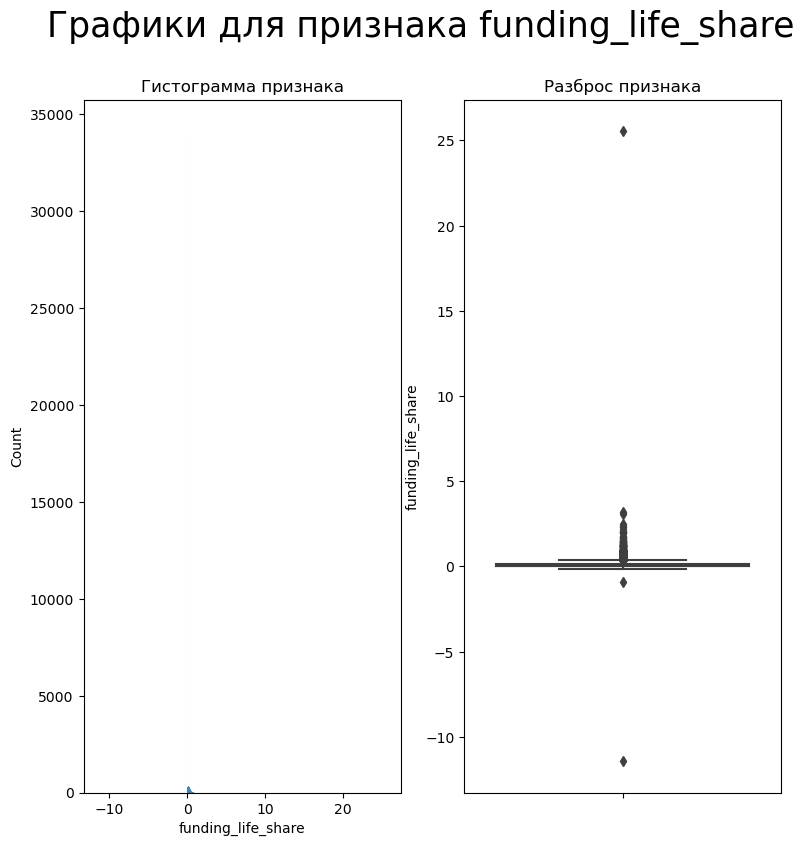

In [20]:
num_hist_boxplot(train_df, numerical_columns_dea)

__Выводы:__
- В среднем 1 раунд финансирования у всех наблюдений
- Присутствует отрицательный lifetime, скорее всего это аномалия
- В среднем между первым и последним финансированием проходит 346 дней
- Присутствуют отрицательные значения времени до первого фандинга перед созданием компании, возможно финансирование поступило на pre seed фазе

In [21]:
#Найдем количество строк
print('Строк с отрицательной продолжительностью', (train_df['lifetime'] < 0).sum())

Строк с отрицательной продолжительностью 28


In [22]:
#Убираем строки
train_df = train_df[train_df['lifetime'] >= 0]

In [23]:
#Сделаем новый признак указывающий на каком моменте получена первая инвестиция (до создания юр. лица или после)
train_df['funding_stage'] = np.where(train_df['first_funding_lt'] < 0, 'pre-seed', 'after seed')
test_df['funding_stage'] = np.where(test_df['first_funding_lt'] < 0, 'pre-seed', 'after seed')

## Изучение качественных данных


In [24]:
def plot_column_data(column_name):
    # Определение статуса целевого признака, None - формула будет принята для всего массива
    statuses = [None, 'operating', 'closed']

    for status in statuses:
        # Фильтрация при уточненом статусе
        if status:
            filtered_df = train_df[train_df['status'] == status.lower()]
        else:
            filtered_df = train_df  # На весь датафрейм если не интересует статус

        # Шаг 1: Разделение и расширение указанного столбца на индивидуальные категории, если они содержат конкатенированные значения
        if filtered_df[column_name].dtype == object and '|' in filtered_df[column_name].iloc[0]:
            categories_expanded = filtered_df[column_name].str.split('|').explode()
        else:
            categories_expanded = filtered_df[column_name]

        # Шаг 2: Подсчёт вхождений каждой категории
        category_counts = categories_expanded.value_counts()

        # Шаг 3: Расчёт процентного соотношения каждой категории
        total_categories = category_counts.sum()
        category_percentage = (category_counts / total_categories) * 100

        # Шаг 4: Выбор 10 наиболее часто встречающихся категорий
        top_10_categories_percentage = category_percentage.head(10)

        # Построение гистограммы
        plt.figure(figsize=(12, 8))
        bars = plt.bar(top_10_categories_percentage.index, top_10_categories_percentage, color='skyblue')
        plt.xlabel(column_name.capitalize())
        plt.ylabel('Процент')
        title_suffix = " для всех статусов" if not status else f" для статуса {status.capitalize()}"
        plt.title(f'Топ 10 {column_name.capitalize()} по процентному соотношению{title_suffix}')
        plt.xticks(rotation=45)

        # Добавление текста над каждым столбцом
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}%', ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

        # Вывод первых пяти категорий
        print(f" Топ 10 имен категории в столбце {column_name.capitalize()}{title_suffix}:")
        print(list(top_10_categories_percentage.index[:9]))

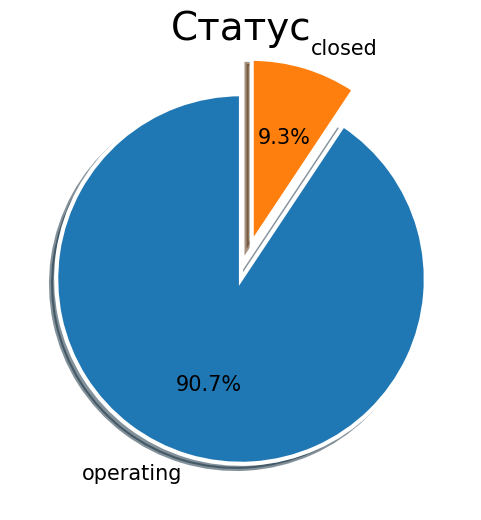

operating    47916
closed        4935
Name: status, dtype: int64


In [25]:
labels = train_df['status'].value_counts().index.tolist()
sizes = train_df['status'].value_counts().tolist()
explode = [0, 0.2]
textprops = {"fontsize":15}

fig, ax = plt.subplots(figsize=(6,6))
ax.set_title('Cтатус', fontsize=28)
ax.pie(sizes, explode=explode, labels=labels, 
       autopct='%1.1f%%', shadow=True, startangle=90, 
       radius = 1, textprops =textprops, wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'})
plt.show()

print(train_df['status'].value_counts())

__Присутствует дисбаланс целевого признака__

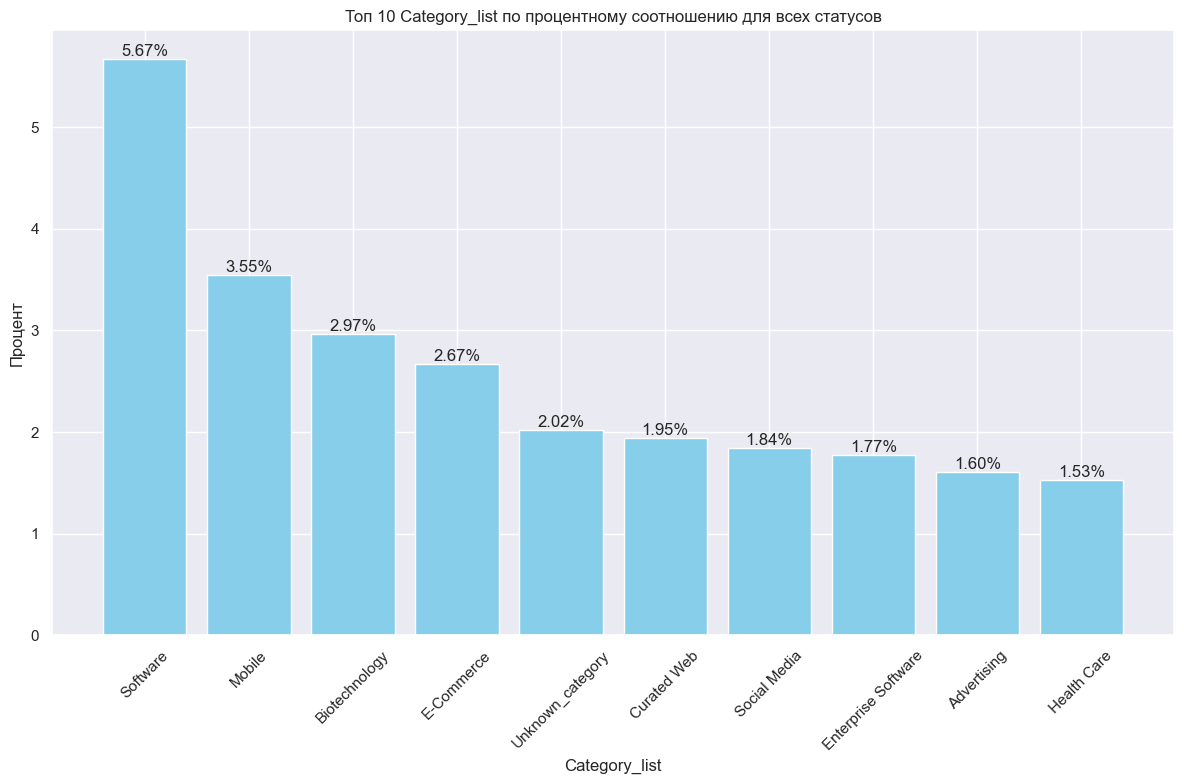

 Топ 10 имен категории в столбце Category_list для всех статусов:
['Software', 'Mobile', 'Biotechnology', 'E-Commerce', 'Unknown_category', 'Curated Web', 'Social Media', 'Enterprise Software', 'Advertising']


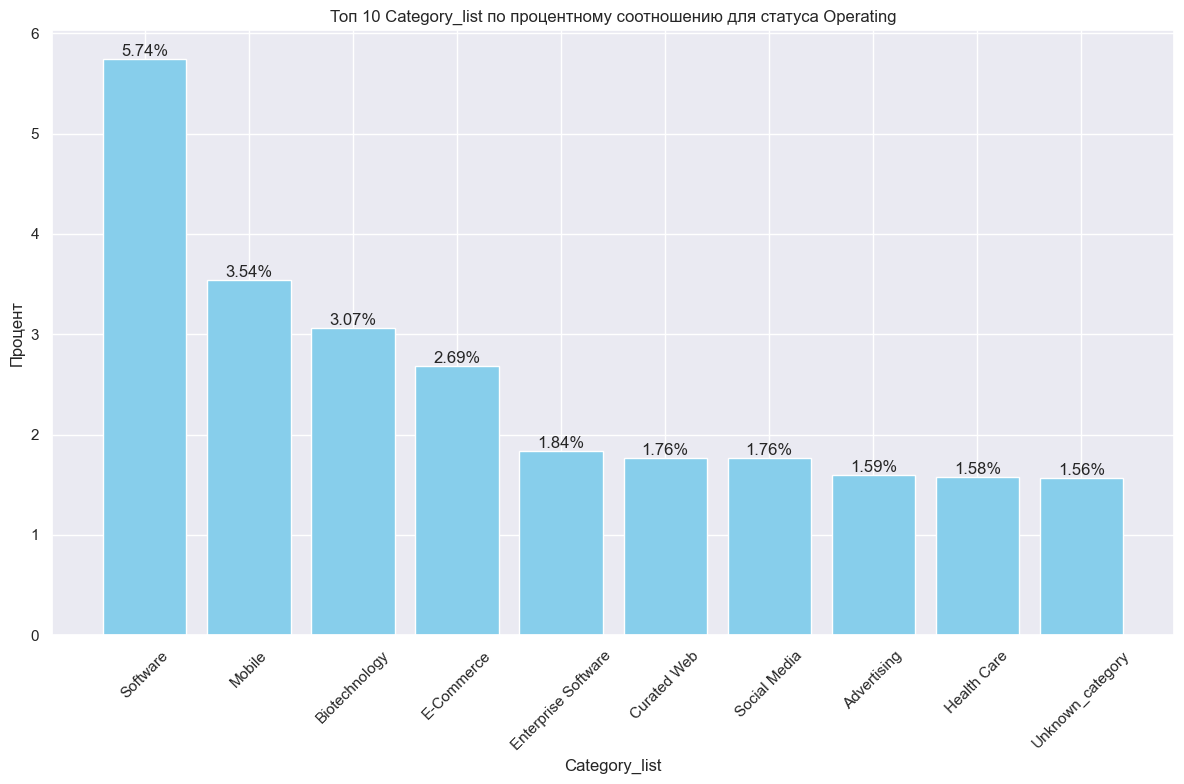

 Топ 10 имен категории в столбце Category_list для статуса Operating:
['Software', 'Mobile', 'Biotechnology', 'E-Commerce', 'Enterprise Software', 'Curated Web', 'Social Media', 'Advertising', 'Health Care']


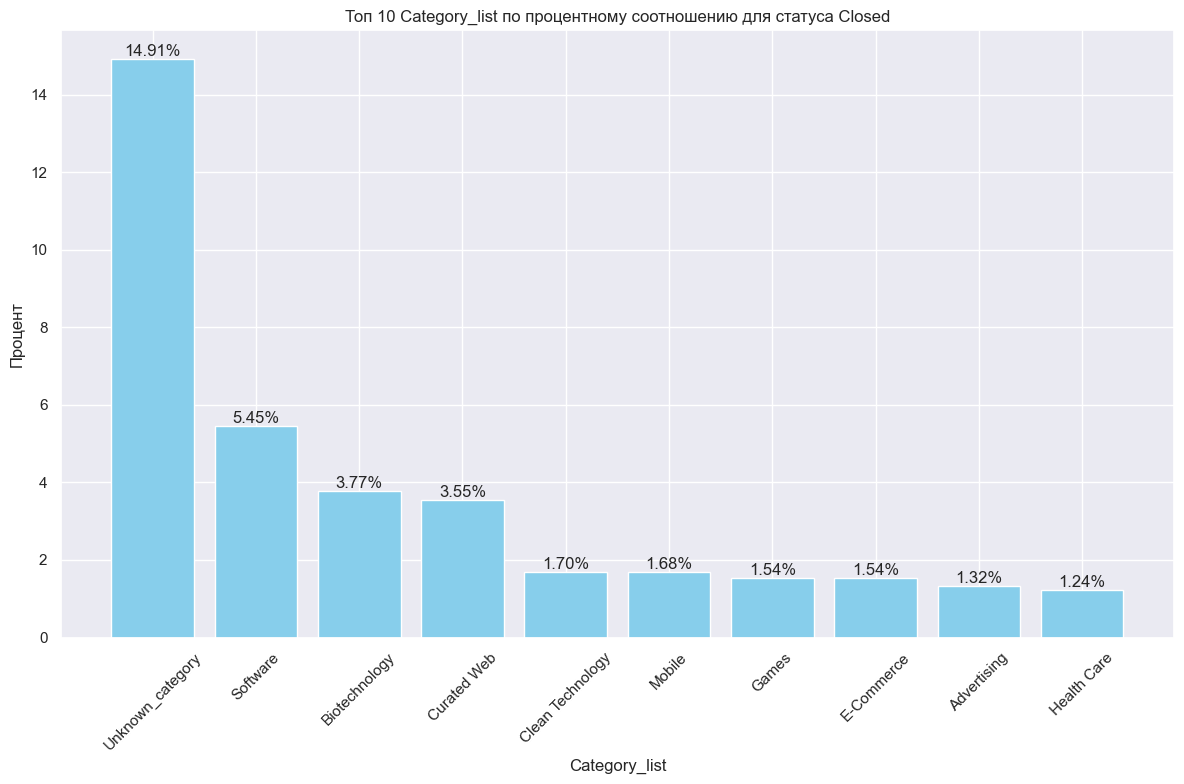

 Топ 10 имен категории в столбце Category_list для статуса Closed:
['Unknown_category', 'Software', 'Biotechnology', 'Curated Web', 'Clean Technology', 'Mobile', 'Games', 'E-Commerce', 'Advertising']


In [61]:
plot_column_data('category_list')

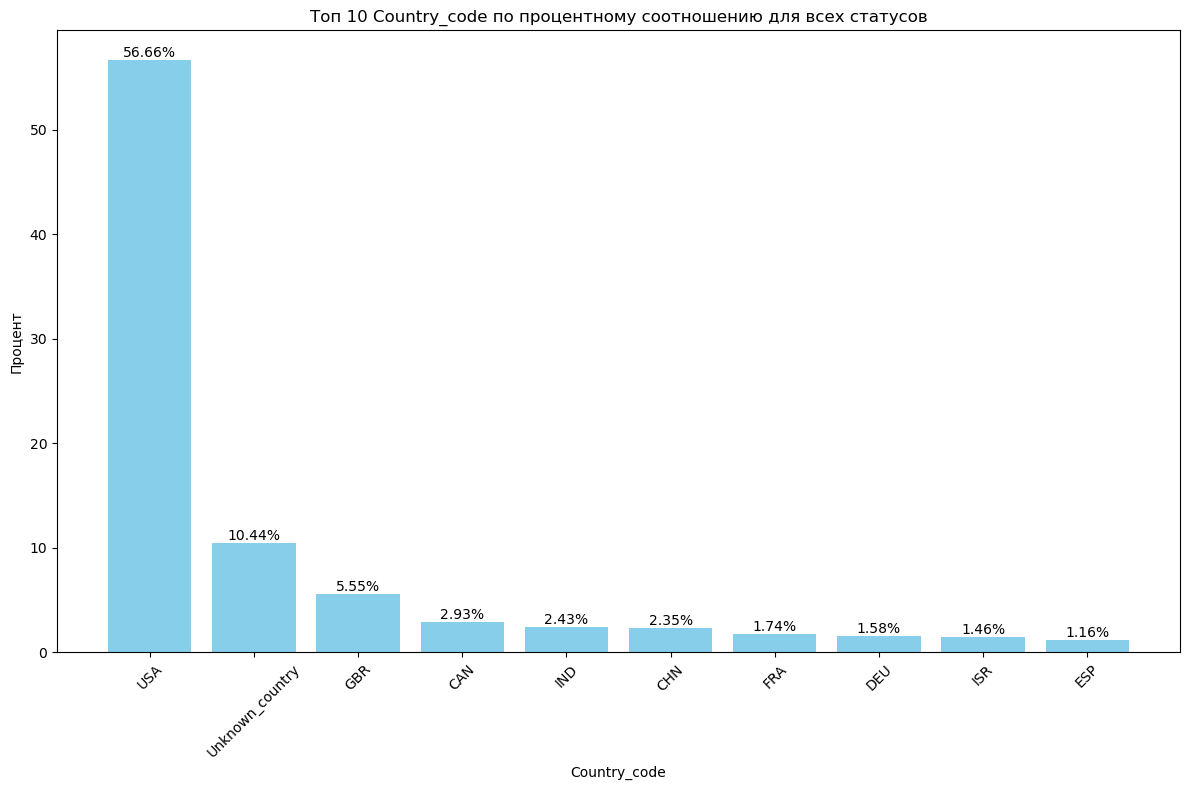

 Топ 10 имен категории в столбце Country_code для всех статусов:
['USA', 'Unknown_country', 'GBR', 'CAN', 'IND', 'CHN', 'FRA', 'DEU', 'ISR']


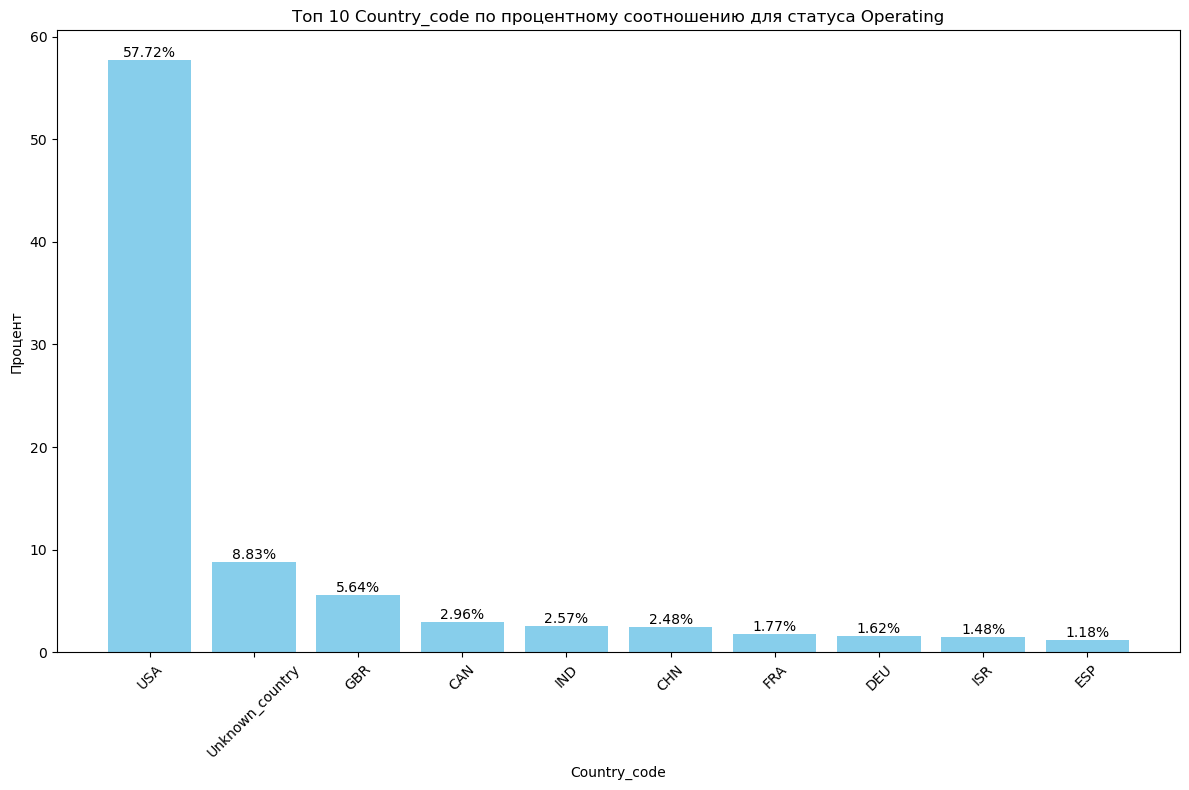

 Топ 10 имен категории в столбце Country_code для статуса Operating:
['USA', 'Unknown_country', 'GBR', 'CAN', 'IND', 'CHN', 'FRA', 'DEU', 'ISR']


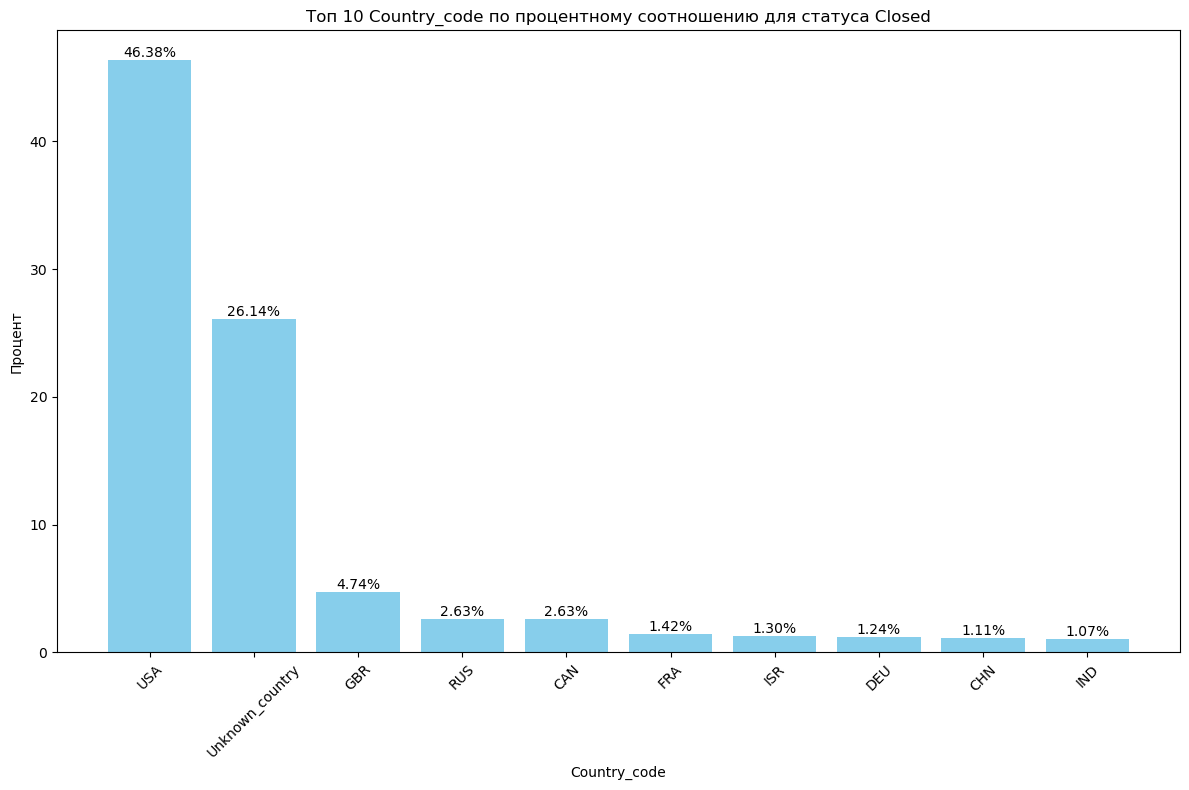

 Топ 10 имен категории в столбце Country_code для статуса Closed:
['USA', 'Unknown_country', 'GBR', 'RUS', 'CAN', 'FRA', 'ISR', 'DEU', 'CHN']


In [27]:
plot_column_data('country_code')

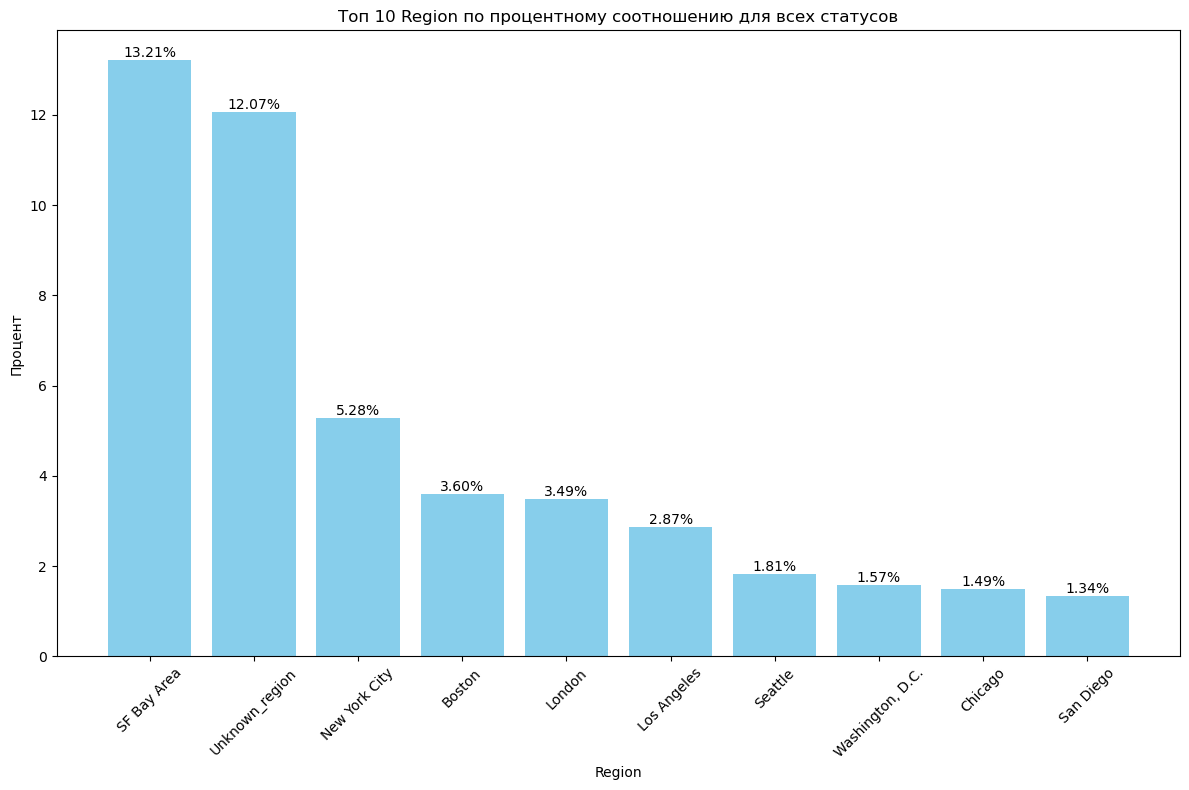

 Топ 10 имен категории в столбце Region для всех статусов:
['SF Bay Area', 'Unknown_region', 'New York City', 'Boston', 'London', 'Los Angeles', 'Seattle', 'Washington, D.C.', 'Chicago']


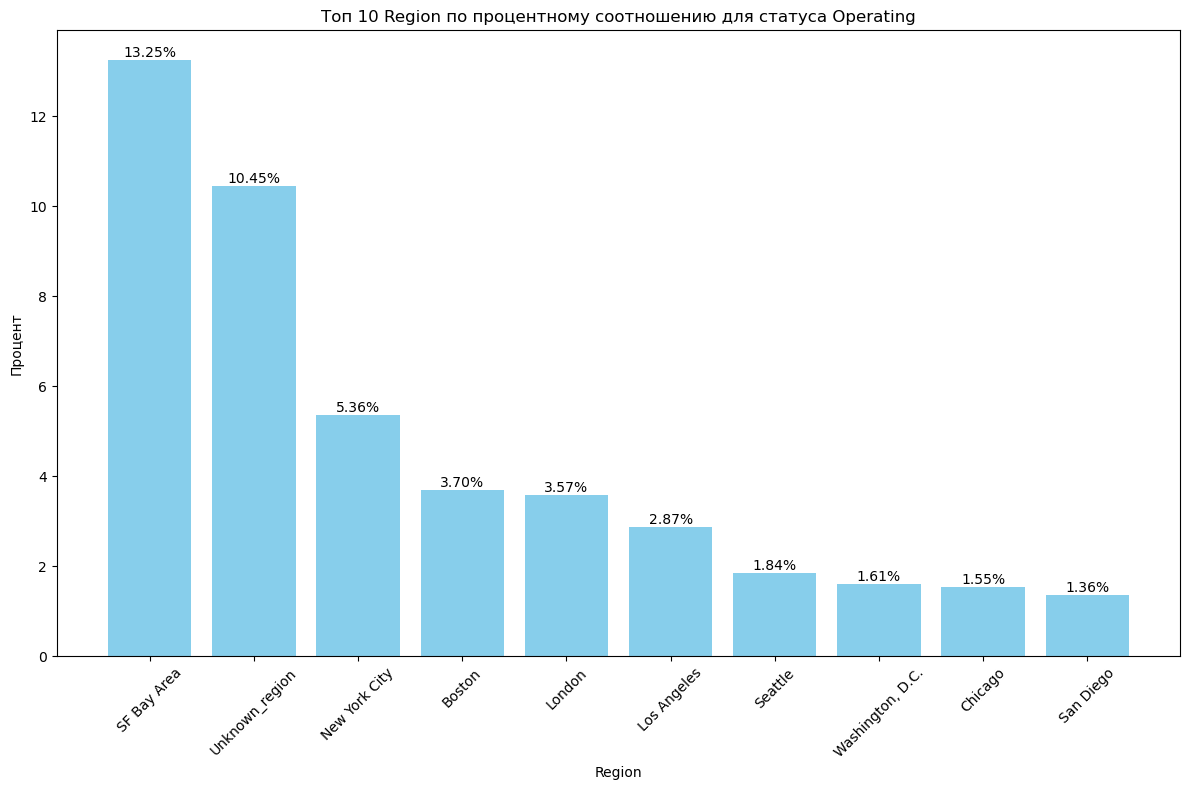

 Топ 10 имен категории в столбце Region для статуса Operating:
['SF Bay Area', 'Unknown_region', 'New York City', 'Boston', 'London', 'Los Angeles', 'Seattle', 'Washington, D.C.', 'Chicago']


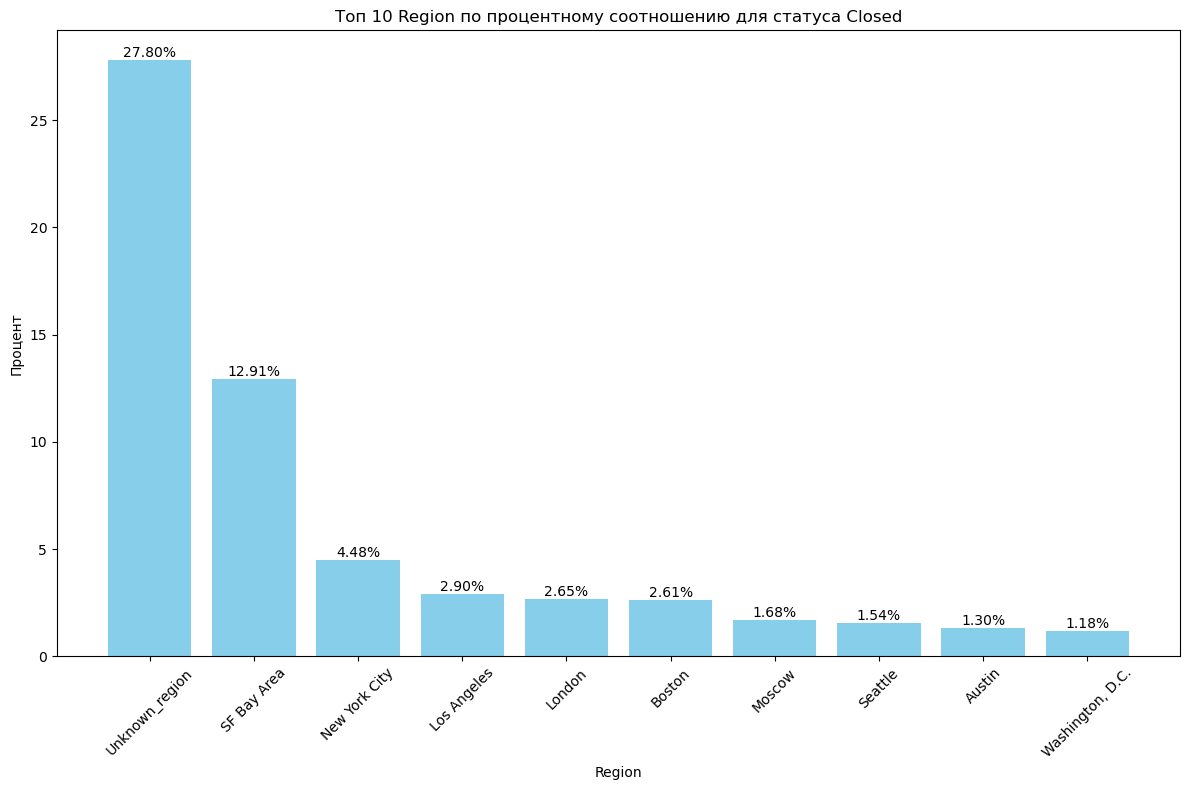

 Топ 10 имен категории в столбце Region для статуса Closed:
['Unknown_region', 'SF Bay Area', 'New York City', 'Los Angeles', 'London', 'Boston', 'Moscow', 'Seattle', 'Austin']


In [28]:
plot_column_data('region')

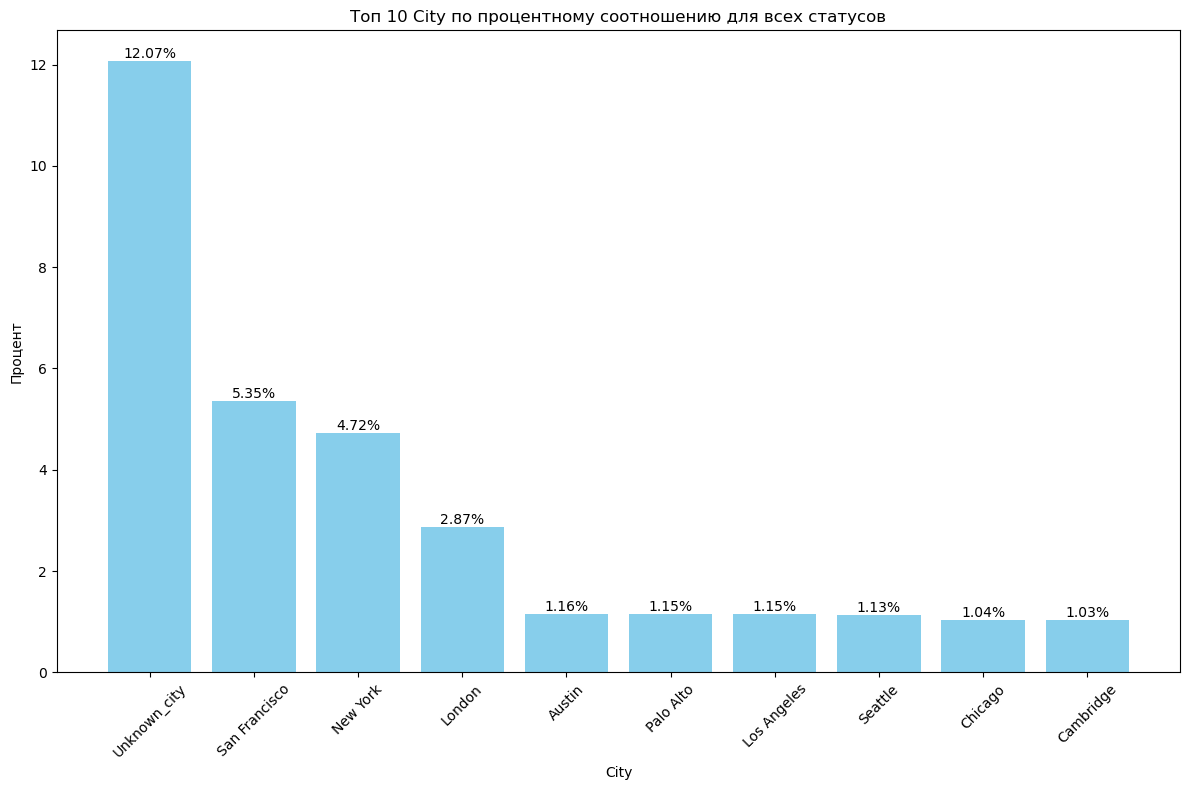

 Топ 10 имен категории в столбце City для всех статусов:
['Unknown_city', 'San Francisco', 'New York', 'London', 'Austin', 'Palo Alto', 'Los Angeles', 'Seattle', 'Chicago']


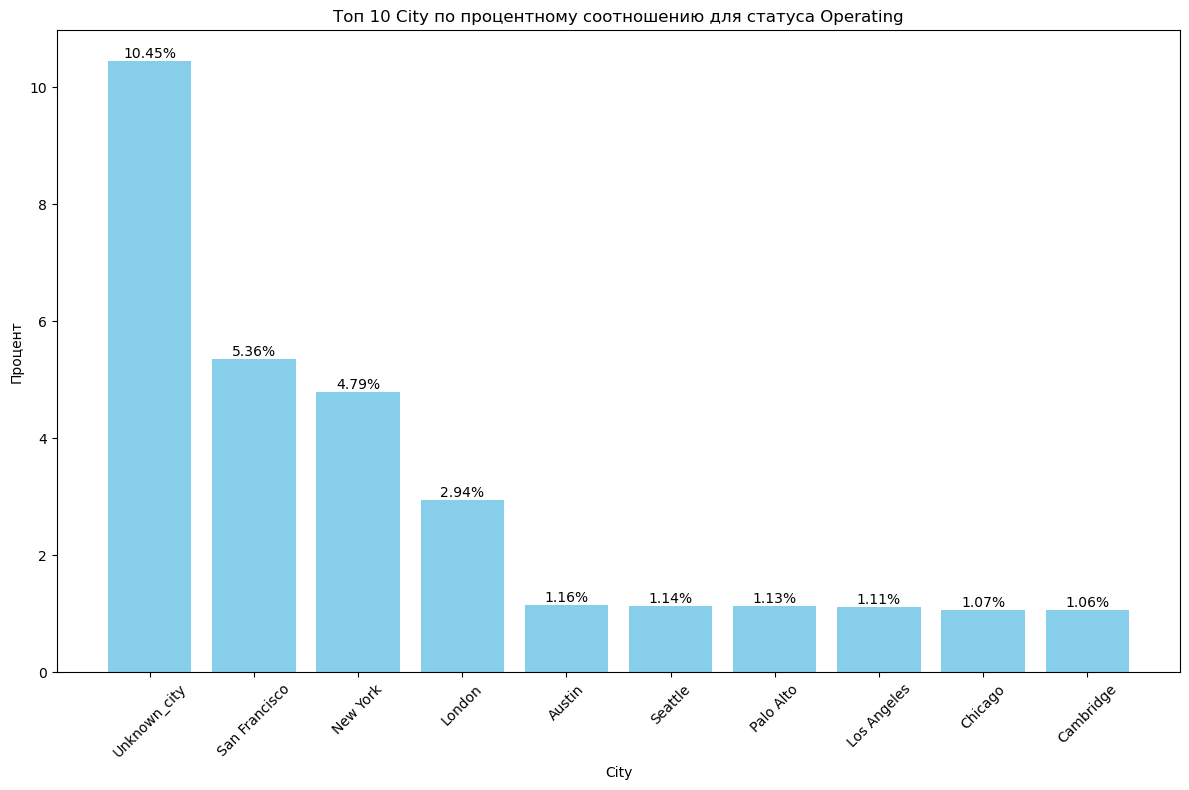

 Топ 10 имен категории в столбце City для статуса Operating:
['Unknown_city', 'San Francisco', 'New York', 'London', 'Austin', 'Seattle', 'Palo Alto', 'Los Angeles', 'Chicago']


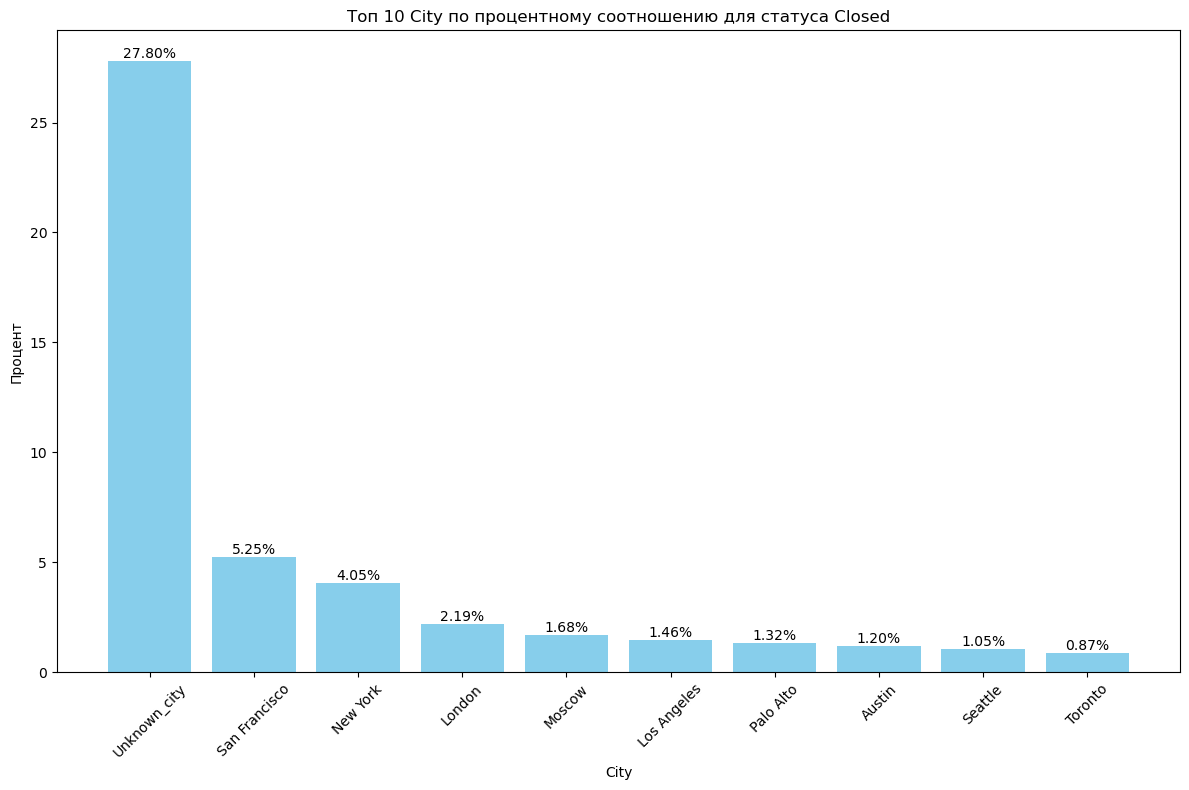

 Топ 10 имен категории в столбце City для статуса Closed:
['Unknown_city', 'San Francisco', 'New York', 'London', 'Moscow', 'Los Angeles', 'Palo Alto', 'Austin', 'Seattle']


In [29]:
plot_column_data('city')

- Присутствует дисбаланс целевого признака
- Топ 10 имен категории в столбце Category_list для статуса Closed: ['Unknown_category', 'Software', 'Biotechnology', 'Curated Web', 'Clean Technology', 'Mobile', 'Games', 'E-Commerce', 'Advertising']. Стартапы по которым неизвестна категория закрывались быстрее всех. 
- Топ 10 имен категории в столбце Country_code для статуса Closed: ['USA', 'Unknown_country', 'GBR', 'RUS', 'CAN', 'FRA', 'ISR', 'DEU', 'CHN']. Закрывшиеся стартапы часто находятся в США, возможно просто по причине того, что они там чаще открываются и закрываются.
- Топ 10 имен категории в столбце Region для статуса Closed: ['Unknown_region', 'SF Bay Area', 'New York City', 'Los Angeles', 'London', 'Boston', 'Moscow', 'Seattle', 'Austin']. Стартапы из неизвестного региона чаще закрывются.
- Топ 10 имен категории в столбце City для статуса Closed: ['Unknown_city', 'San Francisco', 'New York', 'London', 'Moscow', 'Los Angeles', 'Palo Alto', 'Austin', 'Seattle'] 

__Таким образом ключевая находка по закрывшимся стартапам - о них было мало информации__ 

## Корреляционная матрица

In [30]:
# Признаки для содели
columns_to_train = ['funding_stage', 'funding_total_usd', 'status', 'country_code', 'funding_rounds', 'lifetime'
]
columns_to_test = ['funding_stage', 'funding_total_usd', 'country_code', 'funding_rounds', 'lifetime' 
]

# Создание новых датафреймов
new_train_df = train_df[columns_to_train].copy()
X_test_final = test_df[columns_to_test].copy()

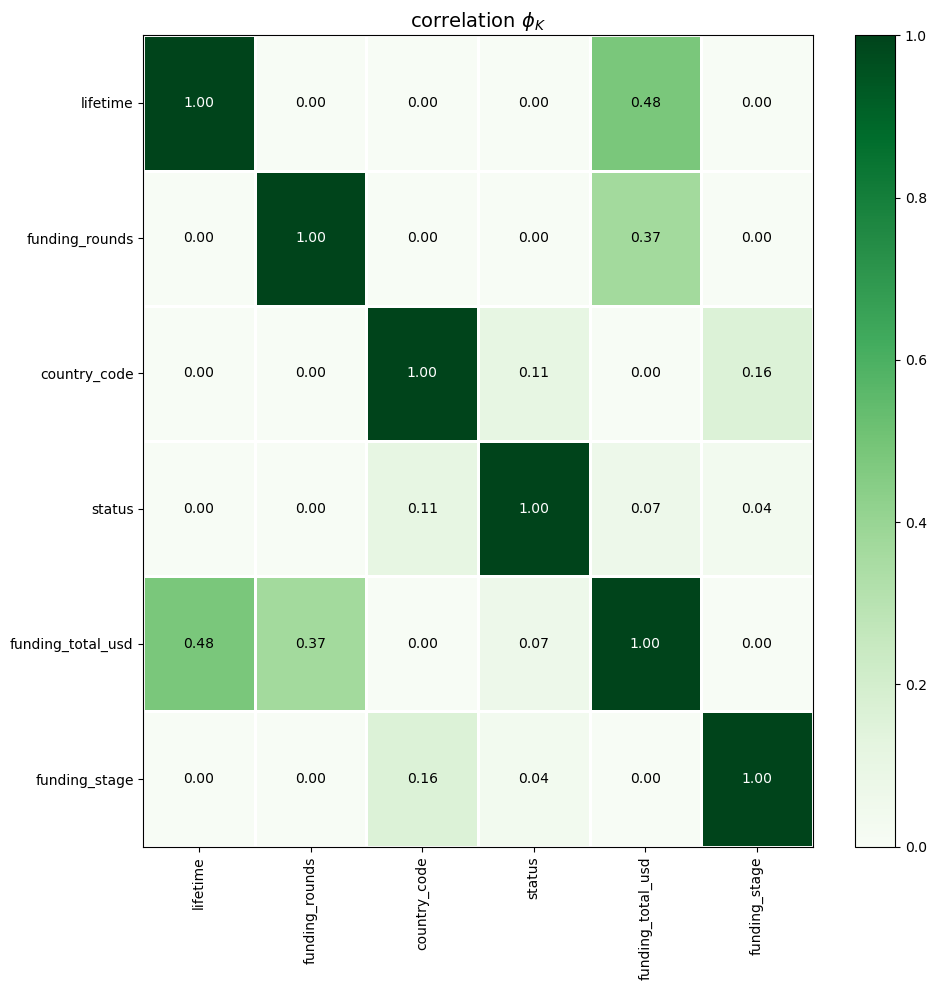

In [31]:
from phik.report import plot_correlation_matrix

phik_overview = new_train_df.sample(1000).phik_matrix(interval_cols=['funding_total_usd', 'funding_rounds', 'lifetime'])
plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map='Greens', title=r'correlation $\phi_K$', fontsize_factor=1,
                        figsize=(10,10))
plt.tight_layout()

Мультиколлинеарность отсутствует. Наибольшая корреляция между раундами финансирования и объемом финансирования. 

## Заключение по исследованию данных

__Анализ количественных данных:__
- В среднем 1 раунд финансирования у всех наблюдений
- Присутствует отрицательный lifetime, скорее всего это аномалия
- В среднем между первым и последним финансированием проходит 346 дней
- Присутствуют отрицательные значения времени до первого фандинга перед созданием компании, возможно финансирование поступило на pre seed фазе

__Анализ качественных данных:__
- Присутствует дисбаланс целевого признака
- Топ 10 имен категории в столбце Category_list для статуса Closed: ['Unknown_category', 'Software', 'Biotechnology', 'Curated Web', 'Clean Technology', 'Mobile', 'Games', 'E-Commerce', 'Advertising']. Стартапы по которым неизвестна категория закрывались быстрее всех. 
- Топ 10 имен категории в столбце Country_code для статуса Closed: ['USA', 'Unknown_country', 'GBR', 'RUS', 'CAN', 'FRA', 'ISR', 'DEU', 'CHN']. Закрывшиеся стартапы часто находятся в США, возможно просто по причине того, что они там чаще открываются и закрываются.
- Топ 10 имен категории в столбце Region для статуса Closed: ['Unknown_region', 'SF Bay Area', 'New York City', 'Los Angeles', 'London', 'Boston', 'Moscow', 'Seattle', 'Austin']. Стартапы из неизвестного региона чаще закрывются.
- Топ 10 имен категории в столбце City для статуса Closed: ['Unknown_city', 'San Francisco', 'New York', 'London', 'Moscow', 'Los Angeles', 'Palo Alto', 'Austin', 'Seattle'] 

__Таким образом ключевая находка по закрывшимся стартапам - о них было мало информации__ 

Мультиколлинеарность отсутствует. Наибольшая корреляция между раундами финансирования и объемом финансирования. 
В модели будем работать со следующими признаками: 'funding_stage', 'funding_total_usd', 'status', 'country_code', 'funding_rounds', 'lifetime'

# Pipeline

In [32]:
TEST_SIZE = 0.4
RANDOM_STATE = 42

## Подготовка данных

In [33]:
# Данные для обучения
X = new_train_df.drop(['status'], axis=1)
y = new_train_df['status']
y = y.replace({'operating':0, 'closed':1})

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = y)

X_train.shape, X_test.shape

((31710, 5), (21141, 5))

In [34]:
ohe_columns = X_train.select_dtypes(exclude='number').columns.tolist()
num_columns = X_train.select_dtypes(exclude='object').columns.tolist()

print('ohe_columns:', ohe_columns)
print('num_columns:', num_columns)

ohe_columns: ['funding_stage', 'country_code']
num_columns: ['funding_total_usd', 'funding_rounds', 'lifetime']


In [35]:
#Пайплайн для подготовки признаков из списка ohe_columns
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', min_frequency = 0.01, max_categories = 30, handle_unknown= 'infrequent_if_exist', sparse=False)
        )
    ]
)

#Общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
) 

In [36]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

#словарь гиперпараметров моделей
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(1,10),
        'models__max_features': range(1,10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1,10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='saga', 
            penalty='l1'
        )],
        'models__C': range(1,10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    }
]

grid = GridSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='f1',
    n_jobs=-1
)

# Обучение и проверка модели

## Обучение

In [37]:
grid.fit(X_train, y_train)

/Users/denis/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/denis/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/denis/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/denis/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/denis/opt/anaconda3/lib/python3.9/site-packag

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='infrequent_if_exist',
                                                                                                        max_categories=30,
                                                                                                        min_frequency=0.01,
                                                                                                        sparse=False))]),
                                                                         ['funding_stage',
                                                                          'countr...
                         {'models': [KNeighborsClassifier()],
                          'models__n_neighbors': range(1, 10),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(), RobustScaler(),
                                                'passthrough']},
                         {'models': [LogisticRegression(penalty='l1',
                                                        random_state=42,
                                                        solver='saga')],
                          'models__C': range(1, 10),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(), RobustScaler(),
                                                'passthrough']}],
             scoring='f1')

In [48]:
print('Лучшая модель и её параметры:\n\n', grid.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', grid.best_score_)

#Запишем модель и предпроцессор
model = grid.best_estimator_.named_steps['models']
preprocessor = grid.best_estimator_.named_steps['preprocessor']

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='infrequent_if_exist',
                                                                                 max_categories=30,
                                                                                 min_frequency=0.01,
                                                                                 sparse=False))]),
                                 

In [39]:
pd.set_option('display.max_colwidth', None)

result = pd.DataFrame(grid.cv_results_)
display(result[
    ['rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score')) 

,rank_test_score,param_models,mean_test_score,params
249,1,"DecisionTreeClassifier(max_depth=7, max_features=9, random_state=42)",0.683038,"{'models': DecisionTreeClassifier(max_depth=7, max_features=9, random_state=42), 'models__max_depth': 7, 'models__max_features': 9, 'preprocessor__num': MinMaxScaler()}"
264,2,"DecisionTreeClassifier(max_depth=7, max_features=9, random_state=42)",0.682798,"{'models': DecisionTreeClassifier(max_depth=7, max_features=9, random_state=42), 'models__max_depth': 8, 'models__max_features': 4, 'preprocessor__num': StandardScaler()}"
267,3,"DecisionTreeClassifier(max_depth=7, max_features=9, random_state=42)",0.682666,"{'models': DecisionTreeClassifier(max_depth=7, max_features=9, random_state=42), 'models__max_depth': 8, 'models__max_features': 4, 'preprocessor__num': 'passthrough'}"
266,4,"DecisionTreeClassifier(max_depth=7, max_features=9, random_state=42)",0.682526,"{'models': DecisionTreeClassifier(max_depth=7, max_features=9, random_state=42), 'models__max_depth': 8, 'models__max_features': 4, 'preprocessor__num': RobustScaler()}"
318,5,"DecisionTreeClassifier(max_depth=7, max_features=9, random_state=42)",0.681703,"{'models': DecisionTreeClassifier(max_depth=7, max_features=9, random_state=42), 'models__max_depth': 9, 'models__max_features': 8, 'preprocessor__num': RobustScaler()}"
...,...,...,...,...
3,375,"DecisionTreeClassifier(max_depth=7, max_features=9, random_state=42)",0.000000,"{'models': DecisionTreeClassifier(max_depth=7, max_features=9, random_state=42), 'models__max_depth': 1, 'models__max_features': 1, 'preprocessor__num': 'passthrough'}"
2,375,"DecisionTreeClassifier(max_depth=7, max_features=9, random_state=42)",0.000000,"{'models': DecisionTreeClassifier(max_depth=7, max_features=9, random_state=42), 'models__max_depth': 1, 'models__max_features': 1, 'preprocessor__num': RobustScaler()}"
1,375,"DecisionTreeClassifier(max_depth=7, max_features=9, random_state=42)",0.000000,"{'models': DecisionTreeClassifier(max_depth=7, max_features=9, random_state=42), 'models__max_depth': 1, 'models__max_features': 1, 'preprocessor__num': MinMaxScaler()}"
379,375,"LogisticRegression(penalty='l1', random_state=42, solver='saga')",0.000000,"{'models': LogisticRegression(penalty='l1', random_state=42, solver='saga'), 'models__C': 5, 'preprocessor__num': 'passthrough'}"


In [40]:
y_pred = grid.predict(X_test)
print(f"F1 = {f1_score(y_test, y_pred, pos_label=1):.2f}")

F1 = 0.69


Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros


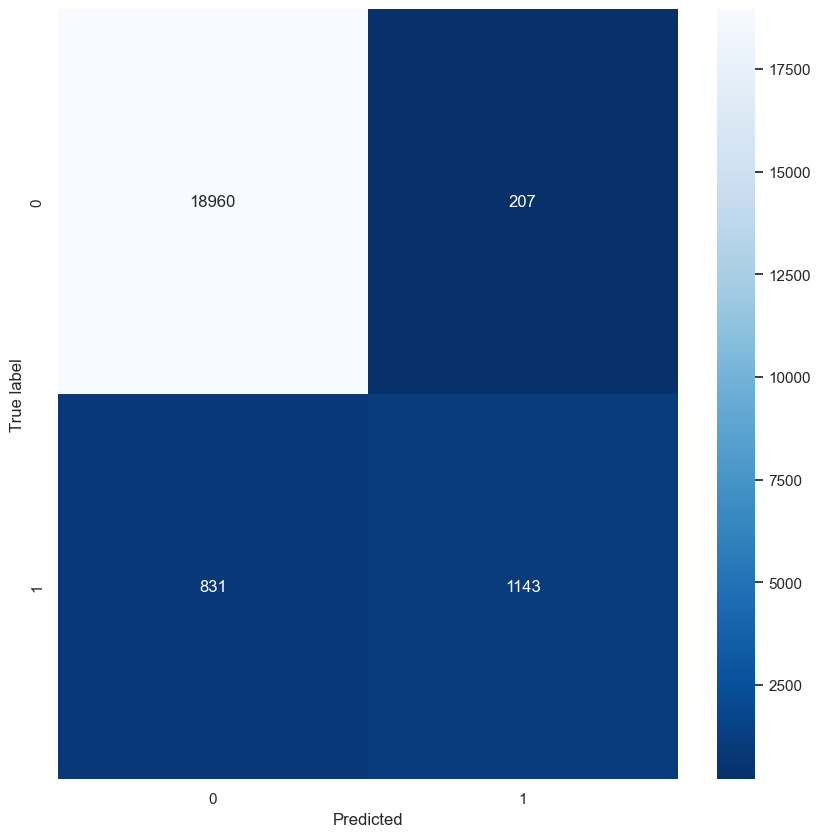

In [47]:
cm = confusion_matrix(y_test, y_pred)
sns.set(rc={'figure.figsize':(10,10)})
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted'); 

False positive ошибки для нас болезнены тем, что мы не найдем гем среди стартапов. Как венчурные инвесторы мы вкладываемся во многие стартапы
но по чуть-чуть. 

## Анализ важности признаков

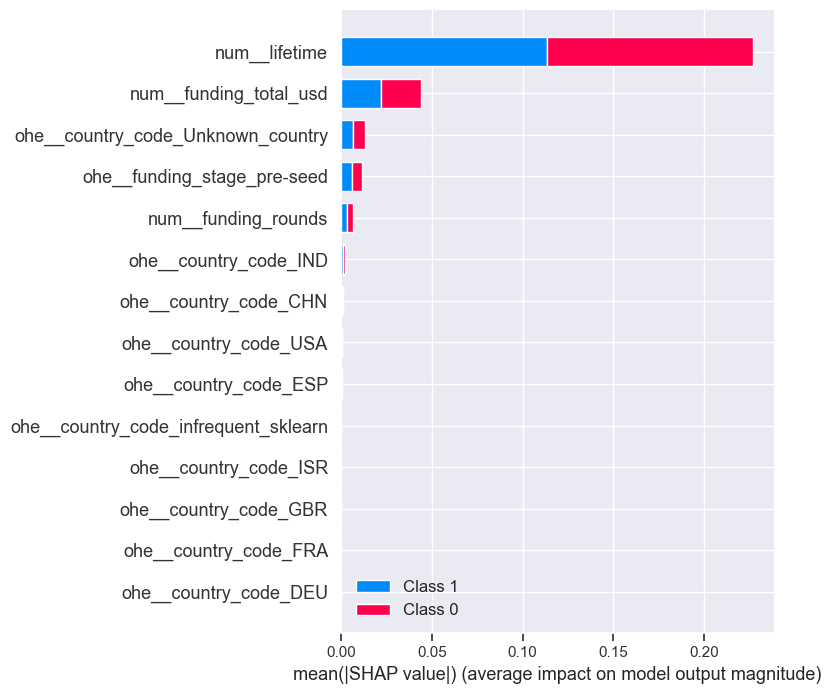

In [62]:
# Подготовка данных для SHAP анализа
X_train_prep = preprocessor.transform(X_train)

# Получаю имена столбцов
feature_names = preprocessor.get_feature_names_out()

# Инициализация 
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_prep)

shap.summary_plot(shap_values, X_train_prep, feature_names=feature_names, plot_type="bar", max_display=30)

## Прогнозирование на данных для итогового теста

In [42]:
#Прогнозируем классификацию для итогового теста
pred_result = grid.predict(X_test_final)

Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros


In [43]:
#Сводим результаты прогноза и имена компаний
results_df = pd.DataFrame({
        'name': test_df['name'],
        'status': pred_result
    })

#Возвращаем наименования статусу
results_df = results_df.replace({0:'operating', 1:'closed'})

## Вывод

__Наилучшая модель:__ 

- DecisionTreeClassifier(max_depth=7, max_features=9, random_state=42)
- MinMaxScaler() применялся для масштабирования числовых признаков
- lifetime наиболее важный признак
- Метрика лучшей модели на кросс-валидации: 0.6830379886708718

# Заключение

## Выводы
__Заключение по загрузке и ознакомлению с данными:__

- Тренировочные данные представлены таблицей размерностью 52879 строк и 13 столбцов
- Тестовые данные представлены 13211 строк и 12 столбцов
- Содержание столбцов схоже, в тестовых данных отсутствует столбец с целевым признаком

Столбцы:
- __name__ - Название стартапа 
- __category_list__ - Индустрия в которой работает стартап
- __funding_total_usd__ - Объем инвестиций
- __status__ - статус функционирования (целевой признак, отсутствует в тестовой выборке)
- __country_code__ - страна 
- __state_code__ - штат
- __region__ - Регион стартапа
- __city__ - Город где функционирует стартап
- __funding_rounds__ - число раундов финансирования
- __founded_at__ - дата создания стартапа
- __first_funding_at__ - дата первого раунда финансирования
- __last_funding_at__ - дата последнего раунда финансирования
- __closed_at__ - дата закрытия стартапа

__Заключение по предподготовке данных:__

- Тренировочный датасет и тестовый датасет имеют схожую статистику по пропускам
- В тренировочном файле дубликаты не выявлены
- 91% наблюдений не содержит информацию о том, когда закрылись компании, а следовательно предполагаем, что они еще работают.
- 5% наблюдений не содержат информацию в каком рынке функционирует стартап
- 10% не содержит информацию о стране происхождения
- 13% о штате происхождения 
- 12% не содержин информацию о регионе происхождения
- 12% не содержит информацию о городе происхождения
- Отсутствующие данные заменены на заглушки
- Изименен тип данных для дат

__Cозданы новые признаки на базе столбцов с датами:__

- lifetime продолжительность жизни стартапа от даты создания до даты закрытия
- funding_length продолжительность жизни стартапа между первым и последним раундом финансирования
- first_funding_lt продолжительность жизни стратапа между первым финансированием и созданием
- funding_life_share - доля жизни стартапа с финансированием

__Анализ количественных данных:__
- В среднем 1 раунд финансирования у всех наблюдений
- Присутствует отрицательный lifetime, скорее всего это аномалия
- В среднем между первым и последним финансированием проходит 346 дней
- Присутствуют отрицательные значения времени до первого фандинга перед созданием компании, возможно финансирование поступило на pre seed фазе

__Анализ качественных данных:__
- Присутствует дисбаланс целевого признака
- Топ 10 имен категории в столбце Category_list для статуса Closed: ['Unknown_category', 'Software', 'Biotechnology', 'Curated Web', 'Clean Technology', 'Mobile', 'Games', 'E-Commerce', 'Advertising']. Стартапы по которым неизвестна категория закрывались быстрее всех. 
- Топ 10 имен категории в столбце Country_code для статуса Closed: ['USA', 'Unknown_country', 'GBR', 'RUS', 'CAN', 'FRA', 'ISR', 'DEU', 'CHN']. Закрывшиеся стартапы часто находятся в США, возможно просто по причине того, что они там чаще открываются и закрываются.
- Топ 10 имен категории в столбце Region для статуса Closed: ['Unknown_region', 'SF Bay Area', 'New York City', 'Los Angeles', 'London', 'Boston', 'Moscow', 'Seattle', 'Austin']. Стартапы из неизвестного региона чаще закрывются.
- Топ 10 имен категории в столбце City для статуса Closed: ['Unknown_city', 'San Francisco', 'New York', 'London', 'Moscow', 'Los Angeles', 'Palo Alto', 'Austin', 'Seattle'] 

__Таким образом ключевая находка по закрывшимся стартапам - о них было мало информации__ 

- Мультиколлинеарность отсутствует. Наибольшая корреляция между раундами финансирования и объемом финансирования. 
- В модели будем работаем со следующими признаками: 'funding_stage', 'funding_total_usd', 'country_code', 'funding_rounds', 'lifetime'

__Наилучшая модель:__ 

- DecisionTreeClassifier(max_depth=7, max_features=9, random_state=42)
- MinMaxScaler() применялся для масштабирования числовых признаков
- lifetime наиболее важный призна
- Метрика лучшей модели на кросс-валидации: 0.6830379886708718


## Предложения по улучшению модели и применение

- Для венчурных инвесторов можно продолжить развитие модели включив анализ порога классификации. 
- Стоит обратить на качество инвесторов осуществивших инвестиции.
- Можно изучить параметры фаундеров, включить информацию о количестве кризисов которые смогла пережить компания


